In [91]:
import os
from osgeo import gdal,ogr,osr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import skbio.diversity.alpha as alpha
import subprocess
import pickle
from sklearn.cluster import KMeans
import gc
import pca_dataflow_V2_variables as vb
from scipy.ndimage import generic_filter

In [2]:
# Adjust the path to match the actual location
input_dir = vb.input_dir
file = vb.file

hdr_file = f"{file}.hdr"

# Check if files exist
if os.path.exists(file):
    print(f"File exists: {file}")
else:
    print(f"File not found: {file}")

if os.path.exists(hdr_file):
    print(f"HDR File exists: {hdr_file}")
else:
    print(f"HDR File not found: {hdr_file}")

File exists: D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\ang20180722t212222_rfl_v2r2_img
HDR File exists: D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\ang20180722t212222_rfl_v2r2_img.hdr


In [3]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(file)

c:\Users\Patrick\anaconda3\envs\geo_env\lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [30]:
test_array = img_open.ReadAsArray()

In [32]:
test_array.shape

(425, 17913, 689)

In [4]:
# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (x-axis):\t"+str(ncols),"Rows (y-axis):\t"+str(nrows)]))

Bands:	425
Cols (x-axis):	689
Rows (y-axis):	17913


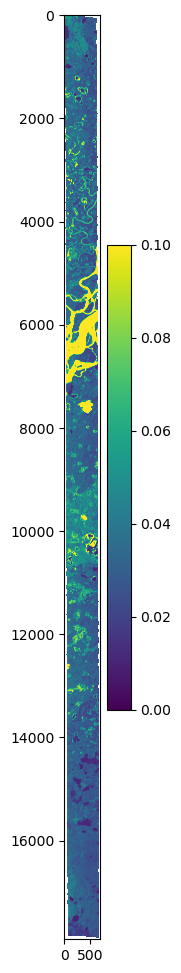

In [5]:
# read and display band 57 just to have a quick look at the image
img_red = img_open.GetRasterBand(57).ReadAsArray()
img_red = np.where(img_red == -9999, np.nan, img_red)
plt.rcParams["figure.figsize"] = [2,12]
plt.rcParams["figure.dpi"] = 100
plt.imshow(img_red,vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

In [6]:
def save_array(output_path, array, gdal_dataset, gdal_format = "GeoTIF", NoDataValue = -9999, data_type=gdal.GDT_Float32):
    """
    Saves a NumPy array as to a file.

    Args:
        output_path (str): The path to save the GeoTIF or ENVI file.
        array (numpy.ndarray): The NumPy array to save.
        gdal_dataset (gdal.Dataset): The GDAL dataset to use for geospatial information.
        gdal_format (str, optional): The GDAL format to use (default: "GTiff").
        NoDataValue (str or number): No data value. Usually -9999, 0 or np.nan.
        data_type (gdal.Datatype): GDT_Float32 or GDT_Byte 
    """
    driver = gdal.GetDriverByName(gdal_format)
    # Determine the number of bands
    if len(array.shape) == 2:  # Single-band array
        num_bands = 1
    elif len(array.shape) == 3:  # Multi-band array
        num_bands = array.shape[2]
    else:
        raise ValueError("Array must have 2 or 3 dimensions.")

    out_raster = driver.Create(
        output_path,
        gdal_dataset.RasterXSize,
        gdal_dataset.RasterYSize,
        num_bands,
        data_type   
    )
    out_raster.SetGeoTransform(gdal_dataset.GetGeoTransform())
    out_raster.SetProjection(gdal_dataset.GetProjection())

    # Write the array band by band
    for i in range(num_bands):
        out_band = out_raster.GetRasterBand(i + 1)
        if num_bands == 1:
            out_band.WriteArray(array)
        else:
            out_band.WriteArray(array[:, :, i])
        out_band.SetNoDataValue(NoDataValue)  # Or use 0 if appropriate
    out_raster.FlushCache()

In [7]:
# Define NoData value
nodata_value = -9999

# Extract the required bands (band 57, 34, and 20)
band_57 = img_open.GetRasterBand(57).ReadAsArray()
band_34 = img_open.GetRasterBand(34).ReadAsArray()
band_20 = img_open.GetRasterBand(20).ReadAsArray()

# Replace NoData values with NaN (or any other appropriate value)
# set fill values (-9999.) to 0 for each array
band_57[band_57 == nodata_value], band_34[band_34 == nodata_value], band_20[band_20 == nodata_value] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
band_57_8bit, band_34_8bit, band_20_8bit = scale8bit(band_57), scale8bit(band_34), scale8bit(band_20)

# set rescaled fill pixels back to 0 for each array
band_57_8bit[band_57 == 0], band_34_8bit[band_34 == 0], band_20_8bit[band_20 == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = band_57_8bit, band_34_8bit, band_20_8bit

In [33]:
rgb_stack.shape

(17913, 689, 3)

In [8]:
# Define output file path
RGB_file = os.path.join(input_dir, "output_rgb_image.tif")

# Save the RGB image as a GeoTIFF
save_array(RGB_file, rgb_stack, img_open,"GTiff",0,gdal.GDT_Byte)

print(f"RGB image saved as {RGB_file}")

RGB image saved as: D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\output_rgb_image.tif


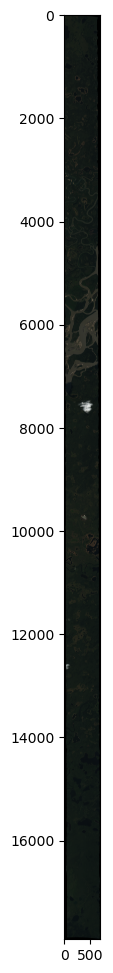

In [9]:
plt.rcParams["figure.figsize"] = [2,12]
plt.rcParams["figure.dpi"] = 100
plt.imshow(rgb_stack)
plt.show()

# Calculate SAVI

In [10]:
# Define band ranges for NIR, Green, and Red
nir_bands = range(86, 106)  # Bands 86 to 105 (1-based indexing in GDAL)
green_bands = range(26, 46)  # Bands 26 to 45
red_bands = range(56, 66)    # Bands 56 to 65

# Function to calculate the mean for a range of bands
def calculate_band_average(img, band_range):
    band_arrays = []
    for band_index in band_range:
        band_data = img.GetRasterBand(band_index).ReadAsArray()  # Read band
        band_data = np.where(band_data == -9999, np.nan, band_data)  # Replace invalid values with NaN
        band_arrays.append(band_data)
    # Stack bands and calculate the mean along the 0th axis
    return np.nanmean(np.stack(band_arrays, axis=0), axis=0)

# Calculate averages for each range
nir_average = calculate_band_average(img_open, nir_bands)
green_average = calculate_band_average(img_open, green_bands)
red_average = calculate_band_average(img_open, red_bands)

C:\Users\Patrick\AppData\Local\Temp\ipykernel_3188\2333493103.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(band_arrays, axis=0), axis=0)


In [11]:
# Define SAVI parameters
SAVI_L = 0.5  # Adjust this based on your requirements
SAVI_threshold = 0.2  # Example threshold for vegetation identification

# Calculate the SAVI
SAVI = ((nir_average - red_average) * (1 + SAVI_L)) / (nir_average + red_average + SAVI_L)

# Create a SAVI mask
savi_mask = np.where(SAVI > SAVI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
#savi_mask = np.where(savi_mask == 0, np.nan, 1)

# Save SAVI and savi_mask

# ENVI format
SAVI_file_envi = os.path.join(input_dir, "SAVI")
SAVI_mask_file_envi = os.path.join(input_dir, "SAVI_mask")
save_array(SAVI_file_envi, SAVI, img_open,"ENVI")
save_array(SAVI_mask_file_envi, savi_mask, img_open,"ENVI")

#Geotiff format
SAVI_file = os.path.join(input_dir, "SAVI.tif")
SAVI_mask_file = os.path.join(input_dir, "SAVI_mask.tif")
save_array(SAVI_file, SAVI, img_open,"GTiff")
save_array(SAVI_mask_file, savi_mask, img_open,"GTiff")

print(f'SAVI mask  saved as {SAVI_mask_file}')

# Calculate NDWI

In [12]:
# Formula: NDWI = (Green – NIR)/(Green + NIR)

# Define NDWI parameters
# The NDWI values correspond to the following ranges:
# 0,2 – 1 – Water surface,
# 0.0 – 0,2 – Flooding, humidity,
# -0,3 – 0.0 – Moderate drought, non-aqueous surfaces,
# -1 – -0.3 – Drought, non-aqueous surfaces

NDWI_threshold = 0.2

# Calculate the SAVI
NDWI = (green_average - nir_average)/(green_average + nir_average)

# Create a SAVI mask
ndwi_mask = np.where(NDWI > NDWI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
ndwi_mask = np.where(ndwi_mask == 0, np.nan, ndwi_mask)

# Save NDWI and ndwi_mask

# ENVI format
NDWI_file_envi = os.path.join(input_dir, "NDWI")
NDWI_mask_file_envi = os.path.join(input_dir, "NDWI_mask")
save_array(NDWI_file_envi, NDWI, img_open,"ENVI")
save_array(NDWI_mask_file_envi, ndwi_mask, img_open,"ENVI")

#Geotiff format
NDWI_file = os.path.join(input_dir, "NDWI.tif")
NDWI_mask_file = os.path.join(input_dir, "NDWI_mask.tif")
save_array(NDWI_file, NDWI, img_open,"GTiff")
save_array(NDWI_mask_file, ndwi_mask, img_open,"GTiff")

print(f'NDWI mask  saved as {NDWI_mask_file}')

# Perform PCA

In [13]:
# Load the SAVI mask
savi_mask_ds = gdal.Open(SAVI_mask_file)
savi_mask = savi_mask_ds.GetRasterBand(1).ReadAsArray()
savi_mask = np.where(savi_mask == 1, 1, np.nan)  # Keep only 1s, set others to NaN

# Prepare hyperspectral image data
bands = img_open.RasterCount  # Number of bands in the image
rows, cols = savi_mask.shape

# Initialize an empty list to store valid pixel data
valid_pixels = []

# Define the bands to include based on bblist
bblist = np.ones((425,))
bblist[0:14] = 0
bblist[189:225] = 0
bblist[281:336] = 0
bblist[405:] = 0

# Convert bblist to boolean mask for included bands
included_bands = np.where(bblist == 1)[0] + 1  # GDAL bands are 1-based
num_included_bands = len(included_bands)

# Loop through only the included bands
valid_pixels = []
for band_index in included_bands:
    band_data = img_open.GetRasterBand(int(band_index)).ReadAsArray()
    band_data = np.where(band_data == -9999, np.nan, band_data)  # Replace no-data values with NaN
    # Apply mask
    masked_data = band_data * savi_mask  # Retain only pixels where mask == 1
    valid_pixels.append(masked_data)

# Stack all bands into a single 3D array (bands, rows, cols)
image_stack = np.stack(valid_pixels, axis=0)

# Flatten the image stack (bands, rows*cols) and remove NaN
flattened_pixels = image_stack.reshape(num_included_bands, -1).T  # Shape: (pixels, included_bands)
filtered_pixels = flattened_pixels[~np.isnan(flattened_pixels).any(axis=1)]  # Exclude NaN

# Standardize the data (scaling)
scaler = StandardScaler()
filtered_pixels_scaled = scaler.fit_transform(filtered_pixels)

# Perform PCA
#n_components = 30  # Maximum number of PCs to retain
#pca = PCA(n_components=n_components)

variance_to_retaine = 0.999
pca = PCA(n_components=variance_to_retaine)

pca_result = pca.fit_transform(filtered_pixels_scaled)  # Shape: (valid_pixels, n_components)

In [14]:
# The number of components remaining
num_components = pca.n_components_
num_selected_pcs = num_components
print(f'Number of components to retain {pca.n_components*100}% variance: {num_components}')

Number of components to retain 99.9% variance: 17


In [15]:
# File path
pca_model_file = os.path.join(input_dir, "pca_model.pkl")
pca_result_file = os.path.join(input_dir, "pca_result.npz")

In [16]:
# Save PCA model using pickle
with open(pca_model_file, "wb") as f:
    pickle.dump(pca, f)

# Save PCA-transformed data using NumPy
np.savez(pca_result_file, pca_result=pca_result)

In [17]:
load_model = False

if(load_model):
    # Load PCA model
    with open(pca_model_file, "rb") as f:
        loaded_pca = pickle.load(f)

    # Load PCA-transformed data
    loaded_data = np.load(pca_result_file)
    loaded_pca_result = loaded_data["pca_result"]


In [18]:
# Access PCA results
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance:", cumulative_variance)

Explained Variance Ratio: [8.24369986e-01 1.31139033e-01 3.23861147e-02 4.81371459e-03
 2.44870960e-03 1.49082971e-03 7.92803175e-04 4.86096155e-04
 2.79608955e-04 2.26141100e-04 1.40894800e-04 1.11219173e-04
 1.00856144e-04 7.67285166e-05 5.58663698e-05 4.95243383e-05
 4.56712290e-05]
Cumulative Variance: [0.82436999 0.95550902 0.98789513 0.99270885 0.99515756 0.99664839
 0.99744119 0.99792729 0.9982069  0.99843304 0.99857393 0.99868515
 0.99878601 0.99886274 0.9989186  0.99896813 0.9990138 ]


In [20]:
#explained_variance_threshold = 0.999

# Select PCs that explain 99% variance
#num_selected_pcs = np.searchsorted(cumulative_variance, explained_variance_threshold) + 1  # Find index where cumulative variance >= 99%
#selected_pcs = pca_result[:, :num_selected_pcs]  # Retain only the selected PCs
all_pcs = pca_result[:, :]


In [21]:
# Create a vector of selected component numbers
selected_component_numbers = list(range(1, num_components + 1))

print(f"PCs selected: {selected_component_numbers}")

# File path
pc_number_file = os.path.join(input_dir, "Selected_Components.txt")

# Open the file in write mode
with open(pc_number_file, "w") as file:
    # Write each number on a new line
    for i in range(1, num_selected_pcs + 1):
        file.write(f"{i}\n")

print(f"Optimal number of clusters saved to {pc_number_file}.")

PCs selected: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Optimal number of clusters saved to D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\Selected_Components.txt.


In [26]:
# Reshape selected PCs back to spatial dimensions
#reshaped_selected_pcs = np.full((num_selected_pcs, rows, cols), np.nan)  # Initialize with NaN
reshaped_pcs = np.full((num_components, rows, cols), np.nan)  # Initialize with NaN
valid_indices = np.where(~np.isnan(flattened_pixels).any(axis=1))[0]

# reshape selected PCs
#for pc_index in range(num_selected_pcs):
#    reshaped_selected_pcs[pc_index][np.unravel_index(valid_indices, (rows, cols))] = selected_pcs[:, pc_index]

# reshape all PCs
for pc_index in range(num_components):
    reshaped_pcs[pc_index][np.unravel_index(valid_indices, (rows, cols))] = all_pcs[:, pc_index]

In [34]:
# Save each PC as a separate band in a GeoTIFF
def save_multiband_tif(output_path, data, gdal_dataset):
    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(output_path,
        gdal_dataset.RasterXSize,
        gdal_dataset.RasterYSize,
        data.shape[0],  # Number of bands
        gdal.GDT_Float32
    )
    out_raster.SetGeoTransform(gdal_dataset.GetGeoTransform())
    out_raster.SetProjection(gdal_dataset.GetProjection())
    
    for band_index in range(data.shape[0]):
        out_band = out_raster.GetRasterBand(band_index + 1)
        out_band.WriteArray(data[band_index])
        out_band.SetNoDataValue(np.nan)
    
    out_raster.FlushCache()

# Save the selected PCs as a GeoTIFF
#PCA_selection_file = os.path.join(input_dir, "PCA_selected.tif")
#save_multiband_tif(PCA_selection_file, reshaped_selected_pcs, img_open)

PCA_file = os.path.join(input_dir, "PCA.tif")
save_multiband_tif(PCA_file, reshaped_pcs, img_open)

print(f'SAVI mask  saved as {PCA_file}')

SAVI mask  saved as D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\PCA.tif


In [35]:
# Save the selected PCs as a GeoTIFF
Rectified_PCA_file = os.path.join(input_dir, "PCA_rectified")
#Rectified_PCA_selection_file = os.path.join(input_dir, "PCA_selection_rectified")

# Construct the GDAL command
gdal_command_rectify = [
    "gdalwarp",
    "-of", "ENVI",                   # Output format
    "-co", "INTERLEAVE=BIL",         # Create ENVI format with BIL interleaving
    "-dstnodata", "-9999",           # Set nodata value
    PCA_file,
    Rectified_PCA_file
]

# Execute the command in Python
try:
    subprocess.run(gdal_command_rectify, check=True)
    print(f"Rectified image saved to {Rectified_PCA_file}")
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")


# Construct the GDAL command
#gdal_command_rectify_selection = [
#    "gdalwarp",
#    "-of", "ENVI",                   # Output format
#    "-co", "INTERLEAVE=BIL",         # Create ENVI format with BIL interleaving
#    "-dstnodata", "-9999",           # Set nodata value
#    PCA_selection_file,
#    Rectified_PCA_selection_file
#]

# Execute the command in Python
#try:
#    subprocess.run(gdal_command_rectify_selection, check=True)
#    print(f"Rectified image saved to {Rectified_PCA_selection_file}")
#except subprocess.CalledProcessError as e:
#    print(f"An error occurred: {e}")

Rectified image saved to D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\PCA_rectified


In [36]:
'''
# Define the total number of bands
#total_bands = nbands

# Define the ranges of bands to exclude
#exclude_1 = range(1, 4)  # Excludes bands 1, 2, 3
#exclude_2 = range(6, 9)  # Excludes bands 6, 7, 8
#exclude_3 = range(11, 16)  # Excludes bands 6, 7, 8

# Combine all the excluded ranges into one list
#excluded_bands = set(exclude_1).union(exclude_2).union(exclude_3)

# Get the list of all band indices
all_bands = list(range(1, num_selected_pcs + 1))

# Exclude the specified bands
# remaining_bands = [str(band) for band in all_bands if band not in excluded_bands]

# Create the string in the desired format
rem_bands = " ".join([f"-b {band}" for band in all_bands])
# Split the string into a list
band_selection_args = rem_bands.split()
#band_selection_args = str(band_selection_args)[1:-1]

# Print the result
print(rem_bands)
print(band_selection_args)
'''

'\n# Define the total number of bands\n#total_bands = nbands\n\n# Define the ranges of bands to exclude\n#exclude_1 = range(1, 4)  # Excludes bands 1, 2, 3\n#exclude_2 = range(6, 9)  # Excludes bands 6, 7, 8\n#exclude_3 = range(11, 16)  # Excludes bands 6, 7, 8\n\n# Combine all the excluded ranges into one list\n#excluded_bands = set(exclude_1).union(exclude_2).union(exclude_3)\n\n# Get the list of all band indices\nall_bands = list(range(1, num_selected_pcs + 1))\n\n# Exclude the specified bands\n# remaining_bands = [str(band) for band in all_bands if band not in excluded_bands]\n\n# Create the string in the desired format\nrem_bands = " ".join([f"-b {band}" for band in all_bands])\n# Split the string into a list\nband_selection_args = rem_bands.split()\n#band_selection_args = str(band_selection_args)[1:-1]\n\n# Print the result\nprint(rem_bands)\nprint(band_selection_args)\n'

In [37]:
'''
def gdal_transform(band_sel, input_file, output_file, output_format):
    # Construct the GDAL command
    gdal_command_subbands = [
        "gdal_translate",
        *band_sel,       #Unpack with asteriks
        "-of", 
        output_format,                   # Output format
        input_file,
        output_file
    ]

    print(gdal_command_subbands)

    # Execute the command in Python
    try:
        result = subprocess.run(gdal_command_subbands, check=True, text=True, capture_output=True)
        print(f"Command succeeded:\n{result.stdout}")
    except subprocess.CalledProcessError as e:
        print(f"Command failed:\n{e.stderr}")
'''

'\ndef gdal_transform(band_sel, input_file, output_file, output_format):\n    # Construct the GDAL command\n    gdal_command_subbands = [\n        "gdal_translate",\n        *band_sel,       #Unpack with asteriks\n        "-of", \n        output_format,                   # Output format\n        input_file,\n        output_file\n    ]\n\n    print(gdal_command_subbands)\n\n    # Execute the command in Python\n    try:\n        result = subprocess.run(gdal_command_subbands, check=True, text=True, capture_output=True)\n        print(f"Command succeeded:\n{result.stdout}")\n    except subprocess.CalledProcessError as e:\n        print(f"Command failed:\n{e.stderr}")\n'

In [38]:
'''
PCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection")
gdal_transform(band_selection_args,PCA_file,PCA_selection_file,"ENVI")
'''

'\nPCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection")\ngdal_transform(band_selection_args,PCA_file,PCA_selection_file,"ENVI")\n'

In [39]:
'''
PCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection.tif")
gdal_transform(band_selection_args,PCA_file,PCA_selection_file,"GTiff")
'''

'\nPCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection.tif")\ngdal_transform(band_selection_args,PCA_file,PCA_selection_file,"GTiff")\n'

# Reset workspace

In [29]:
%reset -f

In [ ]:
gc.collect()

# Perform WSS Elbow Method

In [42]:
import pca_dataflow_V2_variables as vb
PCA_selection_file = os.path.join(input_dir, "PCA.tif")

In [43]:
# open the hyperspectral image file with GDAL
img_open_pca_selection = gdal.Open(PCA_selection_file)

In [44]:
# read a few key properties of the image
nbands_sel = img_open_pca_selection.RasterCount
ncols_sel = img_open_pca_selection.RasterXSize
nrows_sel = img_open_pca_selection.RasterYSize

print("\n".join(["Bands:\t"+str(nbands_sel),"Cols (x-axis):\t"+str(ncols_sel),"Rows (y-axis):\t"+str(nrows_sel)]))

Bands:	17
Cols (x-axis):	689
Rows (y-axis):	17913


In [45]:
'''
# Initialize an empty array to hold the data
pca_data_selection = np.empty((nbands_sel, nrows_sel, ncols_sel), dtype=np.float32)
# Read each band into the array
for i in range(nbands_sel):
    band = img_open_pca_selection.GetRasterBand(i + 1)
    pca_data_selection[i] = band.ReadAsArray()
'''

In [47]:
pca_data_selection = img_open_pca_selection.ReadAsArray()
print(pca_data_selection.shape)

(17, 17913, 689)


In [48]:
# Step 2: Flatten the PCA data
# Reshape into (pixels, bands)
pca_data_selection_2d = pca_data_selection.reshape(nbands_sel, -1).T

# Remove pixels with NaN values
valid_pixels = pca_data_selection_2d[~np.isnan(pca_data_selection_2d).any(axis=1)]

In [52]:
print(f'pca_data_selection_2d shape: {pca_data_selection_2d.shape}')
print(f'valid_pixels shape: {valid_pixels.shape}')

pca_data_selection_2d shape: (12342057, 17)
valid_pixels shape: (9520106, 17)


In [53]:
# Step 3: Apply the elbow method
# Range of cluster counts to try
k_range = range(1, 30)
wcss = []  # Within-cluster sum of squares

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(valid_pixels)
    wcss.append(kmeans.inertia_)
    print(f'Cluster {k} processed')

Exception in thread Thread-96 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\Patrick\anaconda3\envs\geo_env\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Patrick\anaconda3\envs\geo_env\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\Patrick\anaconda3\envs\geo_env\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Patrick\anaconda3\envs\geo_env\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\Patrick\anaconda3\envs\geo_env\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 3: invalid start byte
c:\Users\Patrick\anaconda3\envs\geo_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical co

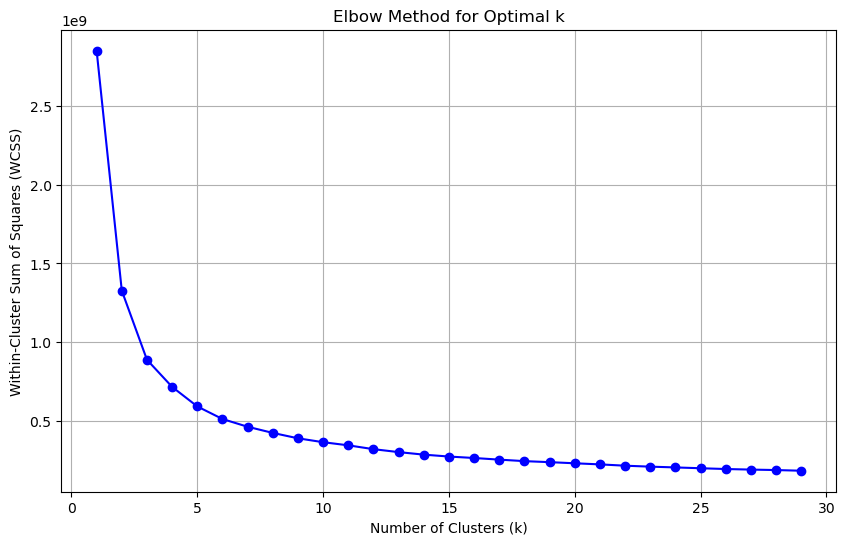

In [54]:
# Step 4: Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

In [55]:
# Step 5: Determine optimal k (manual inspection or heuristic)
optimal_k = k_range[np.argmin(np.diff(wcss, 2)) + 1]  # Using the second derivative heuristic
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 11


In [56]:
output_cluster_file = os.path.join(input_dir, "spectral_species.tif")

In [57]:
# Step 2: Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
cluster_labels = kmeans.fit_predict(valid_pixels)

# Step 3: Reshape clustered data back into spatial dimensions
cluster_image = np.full((nrows_sel, ncols_sel), -9999, dtype=int    )  # Initialize with NaN
valid_indices = np.where(~np.isnan(pca_data_selection_2d).any(axis=1))[0]
cluster_image[np.unravel_index(valid_indices, (nrows_sel, ncols_sel))] = cluster_labels

# Step 4: Save the clustered image as GeoTIFF
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create(
    output_cluster_file, ncols_sel, nrows_sel, 1, gdal.GDT_Int32
)

# Copy georeferencing information from PCA file
out_raster.SetGeoTransform(img_open_pca_selection.GetGeoTransform())
out_raster.SetProjection(img_open_pca_selection.GetProjection())

# Write cluster labels
out_band = out_raster.GetRasterBand(1)
out_band.WriteArray(cluster_image)
out_band.SetNoDataValue(-9999)  # Set NoData value for invalid pixels
out_band.FlushCache()

# Close datasets
out_raster = None
ds = None

print(f"K-means clustering result saved to {output_cluster_file}")

K-means clustering result saved to D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\spectral_species.tif


In [60]:
cluster_image.shape

(17913, 689)

In [ ]:
import skbio.diversity.alpha as alpha
import numpy as np

# Assuming 'counts' is an array of cluster frequencies
shannon = alpha.shannon(counts)
simpson = alpha.simpson(counts) 

In [62]:
%reset -f

In [77]:
import pca_dataflow_V2_variables as vb

In [76]:
gc.collect()

1934

In [84]:
output_cluster_file = os.path.join(vb.input_dir, "spectral_species.tif")

In [97]:
# open the hyperspectral image file with GDAL
spectral_species_img = gdal.Open(output_cluster_file)

In [98]:
spectral_species_img_array = spectral_species_img.ReadAsArray()
print(spectral_species_img_array.shape)

(17913, 689)


In [99]:
# Mask no-data values (-9999) by excluding them
valid_pixels = spectral_species_img_array[spectral_species_img_array != -9999]

print("Valid pixels:", valid_pixels)

Valid pixels: [2 4 4 ... 2 2 2]


In [87]:
# Calculate frequencies for valid clusters
unique, counts = np.unique(valid_pixels, return_counts=True)

# Convert to float for diversity calculations
counts = counts.astype(float)

print("Cluster frequencies:", counts)

Cluster frequencies: [2821951.  653562.  957662. 1110244.   65348. 1801882.  765325.  280295.
  355022. 1311625. 1245890.  973251.]


In [88]:


# Shannon diversity
shannon_index = alpha.shannon(counts)

# Simpson diversity
simpson_index = alpha.simpson(counts)

print(f"Shannon Index: {shannon_index}")
print(f"Simpson Index: {simpson_index}")

Shannon Index: 2.247134502900112
Simpson Index: 0.8765709064979095


In [ ]:
# Define no-data value
no_data_value = -9999

# Step 1: Define a function to calculate Shannon diversity
def calculate_shannon(local_window):
    # Remove no-data values
    valid_values = local_window[local_window != no_data_value]
    if len(valid_values) == 0:  # If all values are no-data, return NaN
        return np.nan

    # Calculate frequencies of unique values
    _, counts = np.unique(valid_values, return_counts=True)
    
    # Compute Shannon diversity
    return shannon(counts.astype(float))

# Step 2: Apply the function to a sliding window
window_size = 3  # Define the neighborhood size (e.g., 3x3)
diversity_map = generic_filter(
    spectral_species_img_array, 
    calculate_shannon, 
    size=window_size, 
    mode='constant', 
    cval=no_data_value
)

# Replace NaN values with the no-data value
diversity_map_cleaned = np.where(np.isnan(diversity_map), no_data_value, diversity_map)

# Step 3: Save the result as a GeoTIFF
def save_geotiff(output_file, array, geo_transform, projection, no_data_value):
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = array.shape
    
    # Create the GeoTIFF file
    dataset = driver.Create(output_file, cols, rows, 1, gdal.GDT_Float32)
    dataset.SetGeoTransform(geo_transform)  # Set the affine transformation
    dataset.SetProjection(projection)  # Set the projection

    # Write the array to the raster band
    band = dataset.GetRasterBand(1)
    band.WriteArray(array)
    band.SetNoDataValue(no_data_value)  # Set no-data value

    # Clean up
    band.FlushCache()
    dataset.FlushCache()
    dataset = None  # Close the file

NameError: name 'input_dir' is not defined

In [101]:
# Save the diversity map
shannon_diversity_file = os.path.join(vb.input_dir, "shannon_diversity.tif")
save_geotiff(shannon_diversity_file, diversity_map_cleaned, spectral_species_img.GetGeoTransform(), spectral_species_img.GetProjection(), no_data_value)

print(f"Diversity map saved to {shannon_diversity_file}")

Diversity map saved to D:\MasterThesis\subzone_e\e_ang20180722t212222rfl\shannon_diversity.tif


In [103]:
import rasterio
import numpy as np
from skbio.diversity.alpha import shannon
from collections import Counter

def shannon_diversity_window(image_path, window_size, output_path, no_data_value=-9999):
    """
    Calculates Shannon diversity index for a clustered image using a moving window, 
    handling no-data values.

    Args:
        image_path (str): Path to the input image (GeoTIFF).
        window_size (int): Size of the moving window (e.g., 3 for a 3x3 window).
        output_path (str): Path to save the output diversity image (GeoTIFF).
        no_data_value (int, optional): Value representing no data in the image. 
                                        Defaults to -9999.
    """
    with rasterio.open(image_path) as src:
        image_data = src.read(1)
        profile = src.profile

        diversity_image = np.empty(image_data.shape, dtype=float)

        for i in range(0, image_data.shape[0] - window_size + 1, window_size):
            for j in range(0, image_data.shape[1] - window_size + 1, window_size):
                window = image_data[i:i+window_size, j:j+window_size]

                # Mask out no-data values in the window
                valid_pixels = window[window != no_data_value] 

                if valid_pixels.size > 0:  # Check if there are valid pixels
                    counts = np.array(list(Counter(valid_pixels).values()))
                    diversity_index = shannon(counts)
                else:
                    diversity_index = no_data_value  # Assign no_data_value if no valid pixels

                center_i = i + window_size // 2
                center_j = j + window_size // 2
                diversity_image[center_i, center_j] = diversity_index

        # Update profile for the output image
        profile.update(dtype=rasterio.float32, count=1, nodata=no_data_value)

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(diversity_image, 1)

# Example usage
input_image = os.path.join(vb.input_dir, "spectral_species.tif") 
window_size = 20  # Example window size
output_image = os.path.join(vb.input_dir, "shannon_diversity_V2.tif")
shannon_diversity_window(input_image, window_size, output_image)